In [53]:

#!pip install doubleml

In [54]:
from doubleml.datasets import fetch_bonus

In [55]:
df_bonus = fetch_bonus('DataFrame')

In [ ]:
df_bonus.head(5)

In [56]:
summary_full = df_bonus.describe()
print(summary_full)

              index          abdt           tg     inuidur1     inuidur2  \
count   5099.000000   5099.000000  5099.000000  5099.000000  5099.000000   
mean    7012.332418  10695.416356     0.342224     2.027585    12.281232   
std     4007.971026    111.180503     0.474501     1.214753    10.362143   
min        0.000000  10404.000000     0.000000     0.000000     0.000000   
25%     3580.500000  10600.000000     0.000000     1.098612     2.000000   
50%     7103.000000  10698.000000     0.000000     2.397895    10.000000   
75%    10499.500000  10796.000000     1.000000     3.218876    23.000000   
max    13911.000000  10880.000000     1.000000     3.951244    52.000000   

            female        black     hispanic      othrace          dep  ...  \
count  5099.000000  5099.000000  5099.000000  5099.000000  5099.000000  ...   
mean      0.404001     0.121985     0.032555     0.007256     0.439694  ...   
std       0.490746     0.327300     0.177487     0.084883     0.757622  ...   

In [57]:
# import matplotlib.pyplot as plt
# df_bonus.hist(bins=30, figsize=(15, 10))
# plt.tight_layout()
# plt.show()

In [58]:
#!pip install seaborn

<Axes: xlabel='inuidur1', ylabel='Count'>

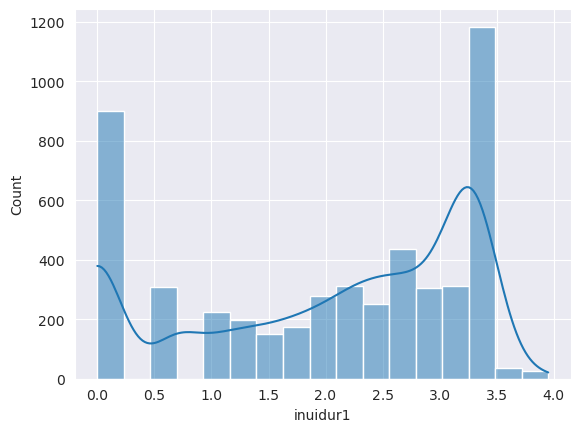

In [59]:
import seaborn as sns

# Plotting a specific variable, e.g., 'treatment_variable_name'
sns.histplot(df_bonus['inuidur1'], kde=True)

In [60]:
# y_cfactual 생성

from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# 데이터셋 로드
# df_bonus는 이미 읽어온 상태라고 가정
# treatment 변수와 outcome 변수를 지정 (변수명을 실제 컬럼명으로 교체)
treatment_col = 'tg'  # 실제 treatment 변수명으로 교체
outcome_col = 'inuidur1'  # 실제 outcome 변수명으로 교체
features = df_bonus.drop(columns=[treatment_col, outcome_col])

# Treatment group 모델 학습
model_treat = LinearRegression()
model_treat.fit(features[df_bonus[treatment_col] == 1], df_bonus.loc[df_bonus[treatment_col] == 1, outcome_col])

# Control group 모델 학습
model_control = LinearRegression()
model_control.fit(features[df_bonus[treatment_col] == 0], df_bonus.loc[df_bonus[treatment_col] == 0, outcome_col])

# 잠재적 결과 예측
df_bonus['y_treat_pred'] = model_treat.predict(features)
df_bonus['y_control_pred'] = model_control.predict(features)

# Counterfactual outcome 생성
df_bonus['counterfactual_outcome'] = np.where(df_bonus[treatment_col] == 1,
                                              df_bonus['y_control_pred'],
                                              df_bonus['y_treat_pred'])

# 결과 확인
print(df_bonus[['inuidur1', 'y_treat_pred', 'y_control_pred', 'counterfactual_outcome']].head())


   inuidur1  y_treat_pred  y_control_pred  counterfactual_outcome
0  2.890372      2.534120        2.576030                2.534120
1  0.000000      0.788370        0.887995                0.788370
2  3.295837      3.492692        3.543029                3.492692
3  2.197225      1.696787        1.748270                1.748270
4  3.295837      3.474261        3.427159                3.474261


In [61]:
# y_factual, y_cfactual, tg -> treatment로 이름 변경

df_bonus.rename(columns={'inuidur1': 'y_factual'}, inplace=True)
df_bonus.rename(columns={'counterfactual_outcome': 'y_cfactual'}, inplace=True)
df_bonus.rename(columns={'tg': 'treatment'}, inplace=True)

# 결과 확인
print(df_bonus.head())

   index   abdt  treatment  y_factual  inuidur2  female  black  hispanic  \
0      0  10824          0   2.890372        18       0      0         0   
1      3  10824          0   0.000000         1       0      0         0   
2      4  10747          0   3.295837        27       0      0         0   
3     11  10607          1   2.197225         9       0      0         0   
4     12  10831          0   3.295837        27       0      0         0   

   othrace  dep  ...  durable  nondurable  lusd  husd  muld  dep1  dep2  \
0        0    2  ...        0           0     0     1     0   0.0   1.0   
1        0    0  ...        0           0     1     0     0   0.0   0.0   
2        0    0  ...        0           0     1     0     0   0.0   0.0   
3        0    0  ...        0           0     0     0     1   0.0   0.0   
4        0    1  ...        1           0     1     0     0   1.0   0.0   

   y_treat_pred  y_control_pred  y_cfactual  
0      2.534120        2.576030    2.534120  


<Axes: xlabel='y_factual', ylabel='Count'>

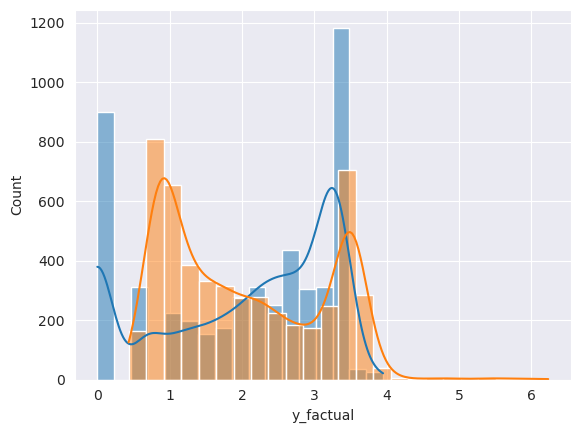

In [62]:
import seaborn as sns

# Plotting a specific variable, e.g., 'treatment_variable_name'
sns.histplot(df_bonus['y_factual'], kde=True)
sns.histplot(df_bonus['y_cfactual'], kde=True)

In [63]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# X는 특성 변수들로 구성된 데이터프레임, df_bonus에서 outcome(y)와 treatment(T)를 제외한 나머지 변수들로 구성
X = df_bonus.drop(columns=['y_factual', 'treatment'])  # 예시로 'treatment'라는 변수 이름 사용

# outcome과 treatment 변수 설정
y = df_bonus['y_factual']
T = df_bonus['treatment']

# treatment 그룹의 모델 (mu1)
model_treated = LinearRegression().fit(X[T == 1], y[T == 1])
mu1 = model_treated.predict(X)


# control 그룹의 모델 (mu0)
model_control = LinearRegression().fit(X[T == 0], y[T == 0])
mu0 = model_control.predict(X)

# 데이터프레임에 mu0과 mu1 추가
df_bonus['mu0'] = mu0
df_bonus['mu1'] = mu1

# 결과 확인
print(df_bonus[['mu0', 'mu1']].head())


        mu0       mu1
0  2.576030  2.528813
1  0.887995  0.775755
2  3.543029  3.486318
3  1.754760  1.696787
4  3.427159  3.480226


<Axes: xlabel='mu0', ylabel='Count'>

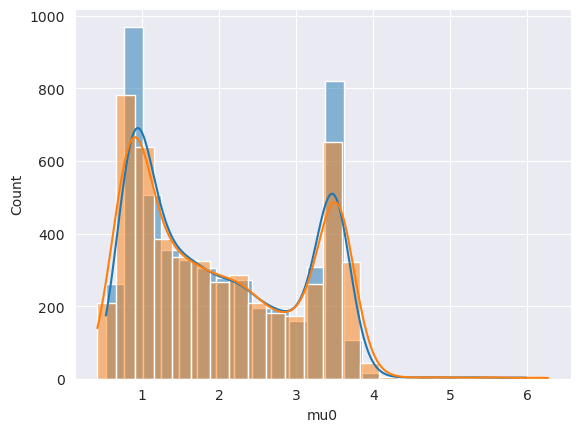

In [64]:
sns.histplot(df_bonus['mu0'], kde=True)
sns.histplot(df_bonus['mu1'], kde=True)

<Axes: xlabel='y_factual', ylabel='Count'>

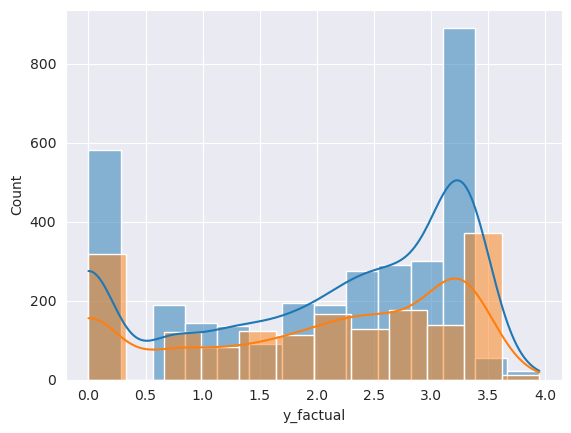

In [65]:
sns.histplot(df_bonus[df_bonus['treatment'] == 0]['y_factual'], kde=True)
sns.histplot(df_bonus[df_bonus['treatment'] == 1]['y_factual'], kde=True)

<Axes: xlabel='y_cfactual', ylabel='Count'>

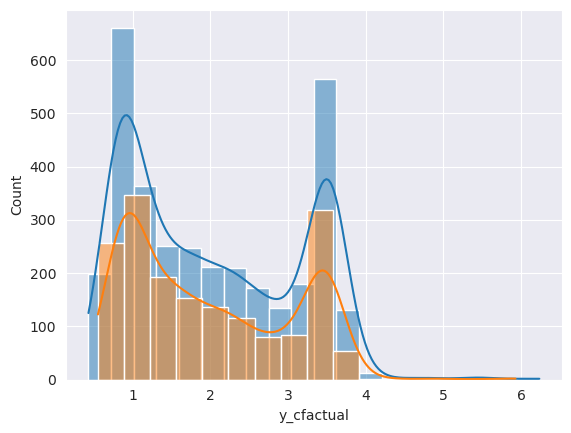

In [66]:
sns.histplot(df_bonus[df_bonus['treatment'] == 0]['y_cfactual'], kde=True)
sns.histplot(df_bonus[df_bonus['treatment'] == 1]['y_cfactual'], kde=True)

In [67]:
for col in df_bonus.columns:
    print(col)

index
abdt
treatment
y_factual
inuidur2
female
black
hispanic
othrace
dep
q1
q2
q3
q4
q5
q6
recall
agelt35
agegt54
durable
nondurable
lusd
husd
muld
dep1
dep2
y_treat_pred
y_control_pred
y_cfactual
mu0
mu1


In [68]:
# covariate 이름 바꾸기
df_bonus.rename(columns={'female': 'x1'}, inplace=True)
df_bonus.rename(columns={'black': 'x2'}, inplace=True)
df_bonus.rename(columns={'hispanic': 'x3'}, inplace=True)
df_bonus.rename(columns={'othrace': 'x4'}, inplace=True)
df_bonus.rename(columns={'dep': 'x5'}, inplace=True)
df_bonus.rename(columns={'q1': 'x6'}, inplace=True)
df_bonus.rename(columns={'q2': 'x7'}, inplace=True)
df_bonus.rename(columns={'q3': 'x8'}, inplace=True)
df_bonus.rename(columns={'q4': 'x9'}, inplace=True)
df_bonus.rename(columns={'q5': 'x10'}, inplace=True)
df_bonus.rename(columns={'q6': 'x11'}, inplace=True)
df_bonus.rename(columns={'recall': 'x12'}, inplace=True)
df_bonus.rename(columns={'agelt35': 'x13'}, inplace=True)
df_bonus.rename(columns={'agegt54': 'x14'}, inplace=True)
df_bonus.rename(columns={'durable': 'x15'}, inplace=True)
df_bonus.rename(columns={'nondurable': 'x16'}, inplace=True)
df_bonus.rename(columns={'lusd': 'x17'}, inplace=True)
df_bonus.rename(columns={'husd': 'x18'}, inplace=True)
df_bonus.rename(columns={'muld': 'x19'}, inplace=True)
df_bonus.rename(columns={'dep1': 'x20'}, inplace=True)
df_bonus.rename(columns={'dep2': 'x21'}, inplace=True)

In [69]:
#불필요한 변수 지우기
df_bonus = df_bonus.drop(['index', 'abdt', 'inuidur2', 'y_treat_pred', 'y_control_pred'], axis=1)

In [70]:
df_bonus.head(5)

,treatment,y_factual,x1,x2,x3,x4,x5,x6,x7,x8,...,x15,x16,x17,x18,x19,x20,x21,y_cfactual,mu0,mu1
0,0,2.890372,0,0,0,0,2,0,0,0,...,0,0,0,1,0,0.0,1.0,2.534120,2.576030,2.528813
1,0,0.000000,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0.0,0.0,0.788370,0.887995,0.775755
2,0,3.295837,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0.0,0.0,3.492692,3.543029,3.486318
3,1,2.197225,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0.0,0.0,1.748270,1.754760,1.696787
4,0,3.295837,0,0,0,0,1,0,0,0,...,1,0,1,0,0,1.0,0.0,3.474261,3.427159,3.480226


In [71]:
df_bonus.shape[0]*0.7

3569.2999999999997

In [72]:
df_bonus_train = df_bonus.iloc[:3569, :]

In [73]:
df_bonus_test = df_bonus.iloc[3569:, :]

In [74]:
# train data
# Fetch the Bonus dataset
X_ =df_bonus_train.iloc[:, 2:23]
y_f = df_bonus_train['y_factual']
y_cf = df_bonus_train['y_cfactual']
mu_0 = df_bonus_train['mu0']
mu_1 = df_bonus_train['mu1']
trt_ = df_bonus_train['treatment']

# Constants
n_samples, n_features = X_.shape  # Number of samples and features
n_experiments = 100  # Number of experiments

# Initialize arrays to store 100 versions of the dataset
x = np.zeros((n_samples, n_features, n_experiments))  # Feature matrix
t = np.zeros((n_samples, n_experiments))  # Treatment assignment (binary)
yf = np.zeros((n_samples, n_experiments))  # Observed outcomes
ycf = np.zeros((n_samples, n_experiments))  # Counterfactual outcomes
mu0 = np.zeros((n_samples, n_experiments))  # Potential outcome under control
mu1 = np.zeros((n_samples, n_experiments))  # Potential outcome under treatment
ate = np.zeros((n_experiments,))  # Average treatment effect
yadd = np.zeros((n_samples, n_experiments))  # Additional outcome
ymul = np.zeros((n_samples, n_experiments))  # Additional outcome

# Generate 100 experiments by introducing slight randomness
np.random.seed(42)
for i in range(n_experiments):
    # Add slight random noise to features
    x[:, :, i] = X_.astype(int)  ^ np.random.randint(0,1, size=X_.shape)
    
    # Generate treatment assignment randomly
    t[:, i] = trt_ #+ np.random.randint(0, 2, size=n_samples)
    
    # Generate potential outcomes under control (mu0) and treatment (mu1)
    mu0[:, i] = mu_0 - 0.5 + np.random.normal(scale=0.1, size=n_samples)
    mu1[:, i] = mu_1 + 0.5 + np.random.normal(scale=0.1, size=n_samples)
    
    # Observed outcome (yf) and counterfactual outcome (ycf)
    yf[:, i] = y_f + 0.5 + np.random.normal(scale=0.1, size=n_samples)
    ycf[:, i] = y_cf + 0.5 + np.random.normal(scale=0.1, size=n_samples)
    
    # Average treatment effect
    ate[i] = np.mean(mu1[:, i] - mu0[:, i])
    
    # Additional synthetic outcomes (yadd, ymul)
    yadd[:, i] = yf[:, i] + np.random.normal(scale=0.1, size=n_samples)
    ymul[:, i] = yf[:, i] * (1 + np.random.normal(scale=0.01, size=n_samples))

# Save the dataset in .npz format
output_path = "/home/yesong/PairNet_DML/catenets/datasets/data/bonus_data.train.npz"
np.savez(
    output_path,
    x=x,
    t=t,
    yf=yf,
    ycf=ycf,
    mu0=mu0,
    mu1=mu1,
    ate=ate,
    yadd=yadd,
    ymul=ymul,
)

print(f"100개의 변형된 Bonus 데이터셋이 {output_path}에 저장되었습니다!")


100개의 변형된 Bonus 데이터셋이 /home/yesong/PairNet_DML/catenets/datasets/data/bonus_data.train.npz에 저장되었습니다!


In [79]:
# test data
# Fetch the Bonus dataset
X_ =df_bonus_test.iloc[:, 2:23]
y_f = df_bonus_test['y_factual']
y_cf = df_bonus_test['y_cfactual']
mu_0 = df_bonus_test['mu0']
mu_1 = df_bonus_test['mu1']
trt_ = df_bonus_test['treatment']

# Constants
n_samples, n_features = X_.shape  # Number of samples and features
n_experiments = 100  # Number of experiments

# Initialize arrays to store 100 versions of the dataset
x = np.zeros((n_samples, n_features, n_experiments))  # Feature matrix
t = np.zeros((n_samples, n_experiments))  # Treatment assignment (binary)
yf = np.zeros((n_samples, n_experiments))  # Observed outcomes
ycf = np.zeros((n_samples, n_experiments))  # Counterfactual outcomes
mu0 = np.zeros((n_samples, n_experiments))  # Potential outcome under control
mu1 = np.zeros((n_samples, n_experiments))  # Potential outcome under treatment
ate = np.zeros((n_experiments,))  # Average treatment effect
yadd = np.zeros((n_samples, n_experiments))  # Additional outcome
ymul = np.zeros((n_samples, n_experiments))  # Additional outcome

# Generate 100 experiments by introducing slight randomness
np.random.seed(42)
for i in range(n_experiments):
    # Add slight random noise to features
    x[:, :, i] = X_.astype(int)  ^ np.random.randint(0,1, size=X_.shape)
    
    # Generate treatment assignment randomly
    t[:, i] = trt_ #+ np.random.randint(0, 2, size=n_samples)
    
    # Generate potential outcomes under control (mu0) and treatment (mu1)
    mu0[:, i] = mu_0 - 0.5 + np.random.normal(scale=0.1, size=n_samples)
    mu1[:, i] = mu_1 + 0.5 + np.random.normal(scale=0.1, size=n_samples)
    
    # Observed outcome (yf) and counterfactual outcome (ycf)
    yf[:, i] = y_f + 0.5 + np.random.normal(scale=0.1, size=n_samples)
    ycf[:, i] = y_cf + 0.5 + np.random.normal(scale=0.1, size=n_samples)
    
    # Average treatment effect
    ate[i] = np.mean(mu1[:, i] - mu0[:, i])
    
    # Additional synthetic outcomes (yadd, ymul)
    yadd[:, i] = yf[:, i] + np.random.normal(scale=0.1, size=n_samples)
    ymul[:, i] = yf[:, i] * (1 + np.random.normal(scale=0.01, size=n_samples))

# Save the dataset in .npz format
output_path = "/home/yesong/PairNet_DML/catenets/datasets/data/bonus_data.test.npz"
np.savez(
    output_path,
    x=x,
    t=t,
    yf=yf,
    ycf=ycf,
    mu0=mu0,
    mu1=mu1,
    ate=ate,
    yadd=yadd,
    ymul=ymul,
)

print(f"100개의 변형된 Bonus 데이터셋이 {output_path}에 저장되었습니다!")

100개의 변형된 Bonus 데이터셋이 /home/yesong/PairNet_DML/catenets/datasets/data/bonus_data.test.npz에 저장되었습니다!


In [85]:
# Boot strapping data

# train data
# Fetch the Bonus dataset
X_ = df_bonus_train.iloc[:, 2:23]
y_f = df_bonus_train['y_factual']
y_cf = df_bonus_train['y_cfactual']
mu_0 = df_bonus_train['mu0']
mu_1 = df_bonus_train['mu1']
trt_ = df_bonus_train['treatment']

# Constants
n_samples, n_features = X_.shape  # Number of samples and features
n_experiments = 500  # Number of experiments
bootstrap_samples = 500  # Number of samples per bootstrap

# Initialize arrays to store bootstrap datasets
x = np.zeros((bootstrap_samples, n_features, n_experiments))  # Feature matrix
t = np.zeros((bootstrap_samples, n_experiments))  # Treatment assignment (binary)
yf = np.zeros((bootstrap_samples, n_experiments))  # Observed outcomes
ycf = np.zeros((bootstrap_samples, n_experiments))  # Counterfactual outcomes
mu0 = np.zeros((bootstrap_samples, n_experiments))  # Potential outcome under control
mu1 = np.zeros((bootstrap_samples, n_experiments))  # Potential outcome under treatment
ate = np.zeros((n_experiments,))  # Average treatment effect
yadd = np.zeros((bootstrap_samples, n_experiments))  # Additional outcome
ymul = np.zeros((bootstrap_samples, n_experiments))  # Additional outcome

# Generate 100 experiments with bootstrap sampling
np.random.seed(42)
for i in range(n_experiments):
    # Bootstrap indices
    bootstrap_indices = np.random.choice(n_samples, size=bootstrap_samples, replace=True)

    # Bootstrap sampling
    x[:, :, i] = X_.iloc[bootstrap_indices].astype(int).values
    t[:, i] = trt_.iloc[bootstrap_indices].values
    mu0[:, i] = mu_0.iloc[bootstrap_indices].values
    mu1[:, i] = mu_1.iloc[bootstrap_indices].values
    yf[:, i] = y_f.iloc[bootstrap_indices].values
    ycf[:, i] = y_cf.iloc[bootstrap_indices].values

    # Add randomness to potential outcomes
    mu0[:, i] += np.random.normal(scale=0.1, size=bootstrap_samples)
    mu1[:, i] += np.random.normal(scale=0.1, size=bootstrap_samples)

    # Observed outcome (yf) and counterfactual outcome (ycf)
    yf[:, i] += np.random.normal(scale=0.1, size=bootstrap_samples)
    ycf[:, i] += np.random.normal(scale=0.1, size=bootstrap_samples)

    # Average treatment effect
    ate[i] = np.mean(mu1[:, i] - mu0[:, i])

    # Additional synthetic outcomes (yadd, ymul)
    yadd[:, i] = yf[:, i] + np.random.normal(scale=0.1, size=bootstrap_samples)
    ymul[:, i] = yf[:, i] * (1 + np.random.normal(scale=0.01, size=bootstrap_samples))

# Save the dataset in .npz format
output_path = "/home/yesong/PairNet_DML/catenets/datasets/data/bonus_data.train_bootstrap.npz"
np.savez(
    output_path,
    x=x,
    t=t,
    yf=yf,
    ycf=ycf,
    mu0=mu0,
    mu1=mu1,
    ate=ate,
    yadd=yadd,
    ymul=ymul,
)

print(f"500개의 부트스트래핑 데이터셋이 {output_path}에 저장되었습니다!")


500개의 부트스트래핑 데이터셋이 /home/yesong/PairNet_DML/catenets/datasets/data/bonus_data.train_bootstrap.npz에 저장되었습니다!


In [87]:
# Fetch the Bonus dataset
X_ = df_bonus_test.iloc[:, 2:23]
y_f = df_bonus_test['y_factual']
y_cf = df_bonus_test['y_cfactual']
mu_0 = df_bonus_test['mu0']
mu_1 = df_bonus_test['mu1']
trt_ = df_bonus_test['treatment']

# Constants
n_samples, n_features = X_.shape  # Number of samples and features
bootstrap_samples = 500
n_experiments = 500  # Number of bootstrap experiments

# Initialize arrays to store bootstrap datasets
x = np.zeros((bootstrap_samples, n_features, n_experiments))  # Feature matrix
t = np.zeros((bootstrap_samples, n_experiments))  # Treatment assignment (binary)
yf = np.zeros((bootstrap_samples, n_experiments))  # Observed outcomes
ycf = np.zeros((bootstrap_samples, n_experiments))  # Counterfactual outcomes
mu0 = np.zeros((bootstrap_samples, n_experiments))  # Potential outcome under control
mu1 = np.zeros((bootstrap_samples, n_experiments))  # Potential outcome under treatment
ate = np.zeros((n_experiments,))  # Average treatment effect
yadd = np.zeros((bootstrap_samples, n_experiments))  # Additional outcome
ymul = np.zeros((bootstrap_samples, n_experiments))  # Additional outcome

# Generate bootstrap samples for test data
np.random.seed(42)
for i in range(n_experiments):
    # Bootstrap sampling: Random sampling with replacement
    bootstrap_indices = np.random.choice(n_samples, size=bootstrap_samples, replace=True)

    # Use bootstrap samples to populate datasets
    x[:, :, i] = X_.iloc[bootstrap_indices, :].values  # Bootstrap sample features
    t[:, i] = trt_.iloc[bootstrap_indices].values  # Bootstrap treatment assignments
    mu0[:, i] = mu_0.iloc[bootstrap_indices].values  # Bootstrap potential outcomes (control)
    mu1[:, i] = mu_1.iloc[bootstrap_indices].values  # Bootstrap potential outcomes (treatment)
    yf[:, i] = y_f.iloc[bootstrap_indices].values  # Bootstrap observed outcomes
    ycf[:, i] = y_cf.iloc[bootstrap_indices].values  # Bootstrap counterfactual outcomes

    # Average treatment effect
    ate[i] = np.mean(mu1[:, i] - mu0[:, i])

    # Additional synthetic outcomes (yadd, ymul)
    yadd[:, i] = yf[:, i] + np.random.normal(scale=0.1, size=bootstrap_samples)
    ymul[:, i] = yf[:, i] * (1 + np.random.normal(scale=0.01, size=bootstrap_samples))

# Save the dataset in .npz format
output_path = "/home/yesong/PairNet_DML/catenets/datasets/data/bonus_data.test_bootstrap.npz"
np.savez(
    output_path,
    x=x,
    t=t,
    yf=yf,
    ycf=ycf,
    mu0=mu0,
    mu1=mu1,
    ate=ate,
    yadd=yadd,
    ymul=ymul,
)

print(f"500개의 부트스트랩된 Bonus 테스트 데이터셋이 {output_path}에 저장되었습니다!")

500개의 부트스트랩된 Bonus 테스트 데이터셋이 /home/yesong/PairNet_DML/catenets/datasets/data/bonus_data.test_bootstrap.npz에 저장되었습니다!


array([[2.21794654, 1.8443852 , 0.97517731, ..., 0.85383913, 3.61040171,
        2.11758692],
       [0.83639258, 0.72572103, 2.64220996, ..., 2.29861731, 0.82567317,
        1.31851122],
       [0.95317076, 1.25830115, 3.39949908, ..., 0.85383913, 1.45468746,
        1.70683574],
       ...,
       [1.78896029, 0.70271216, 0.90420789, ..., 1.66516753, 1.5054684 ,
        2.11025262],
       [3.62499815, 1.80533035, 3.51275824, ..., 1.12894911, 0.85679167,
        1.17672316],
       [1.85792017, 3.41842757, 0.89184068, ..., 2.20448559, 3.61104795,
        3.35993257]])